In [2]:
# PyTorch imports
from torch.utils.data import Dataset
import h5py
import numpy as np
import math
import numpy.ma as ma
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import savez
import random
import PlottingEventDisplays

In [3]:
# for event displays
csv_file = "mPMT_to_row_col.csv"
num_pmts = 15808
#mPMT_to_index = PlottingEventDisplays.GenMapping(csv_file)
#PMT_to_index = PlottingEventDisplays.gen_mpmt_mapping()

# load data and indices
trainval_dset_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M_splits_CNN/IWCDmPMT_4pi_fulltank_9M_trainval.h5"
f = h5py.File(trainval_dset_path, "r")
trainval_idx_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M_splits_CNN/IWCDmPMT_4pi_fulltank_9M_trainval_idxs.npz"
        
hdf5_event_data = f["event_data"]
hdf5_labels = f["labels"]
hdf5_energies = f["energies"]
hdf5_positions = f["positions"]
hdf5_angles = f["angles"]

assert hdf5_event_data.shape[0] == hdf5_labels.shape[0]

# Create a memory map for event_data - loads event data into memory only on __getitem__()
event_data = np.memmap(trainval_dset_path, mode="r", shape=hdf5_event_data.shape,
                            offset=hdf5_event_data.id.get_offset(), dtype=hdf5_event_data.dtype)
#self.event_data = self.event_data[:,:,:,0:19]

# Load the contents which could fit easily into memory
labels = np.array(hdf5_labels)
energies = np.array(hdf5_energies)
positions = np.array(hdf5_positions)
angles = np.array(hdf5_angles)

trainval_indices = np.load(trainval_idx_path, allow_pickle=True)
train_indices = trainval_indices["train_idxs"]
val_indices = trainval_indices["val_idxs"]
print(labels.shape)
print(labels[train_indices].shape)
print(labels[val_indices].shape)
print(event_data.shape)

(5026528,)
(4188774,)
(837754,)
(5026528, 40, 40, 38)


In [4]:
test_dset_path = "/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M_splits_CNN/IWCDmPMT_4pi_fulltank_9M_test.h5"
f = h5py.File(test_dset_path, "r")

hdf5_event_data = f["event_data"]
hdf5_labels = f["labels"]
hdf5_energies = f["energies"]
hdf5_positions = f["positions"]
hdf5_angles = f["angles"]

test_event_data = np.memmap(test_dset_path, mode="r", shape=hdf5_event_data.shape,
                                    offset=hdf5_event_data.id.get_offset(), dtype=hdf5_event_data.dtype)

test_labels = np.array(hdf5_labels)
test_energies = np.array(hdf5_energies)
test_positions = np.array(hdf5_positions)
test_angles = np.array(hdf5_angles)
print(test_labels.shape[0])
test_indices = np.arange(test_labels.shape[0])
np.random.shuffle(test_indices)
print(max(test_positions[:,0,1]))

3351020
520.99927


In [12]:
# determining information about location of event in root files
print(f.keys())
print(type(f['event_ids']))
test_ids = np.array(f['event_ids'])
print(test_ids.shape)
print(min(test_ids))
print(np.unique(test_ids).shape)
print((test_ids == 2999).sum())
print("Index: ", test_ids[1])


<KeysViewHDF5 ['angles', 'energies', 'event_data', 'event_ids', 'labels', 'positions']>
<class 'h5py._hl.dataset.Dataset'>
(3351020,)
0
(3000,)
1130
Index:  4
3146.8333
1160.2572
13.0274


In [5]:
# particle labels
label_dict = {0:["gamma", "red"], 1:["e", "blue"], 2:["mu", "green"]}

# particle masses (in MeV)
mass_dict = {0:1.02, 1:0.511, 2:105.6583}
e = 0.511
mu = 105.6583
gamma = 1.02

# angle from end cap to center of barrel - max cherenkov angle
theta = math.atan(420/475) - math.acos(1/1.33)

print(mass_dict[1])
print(labels[val_indices].shape)
print(energies[train_indices].shape)

0.511
(837754,)
(4188774, 1)


In [6]:
# returns the max and min angle at which cherenkov radiation will hit the tank 
# and the max and min distance of the cherenkov ring to the wall of the barrel
def find_bounds(pos, ang, label, energy):
    # Input parameters:
    # pos - array of position of particles
    # ang - array polar and azimuth angles of particle
    # label - array type of particle
    # energy - array particle energy
    # ***all parameters should have same size of first dimension
    
    # This is (I believe) what John told me the max Cherenkov emission angle would be
    max_ang = abs(np.arccos(1/(1.33)))*(1 + abs(pos[:,1]/max(pos[:,1]))*0.5)
    theta = ang[:,1]
    phi = ang[:,0]
    
    # radius and height of barrel
    r = 400
    tank_height = 520
    
    # position of particle in barrel
    end = np.array([pos[:,0], pos[:,2]]).transpose()
    
    # *********************
    # Calculate intersection with the wall
    # This is done for the particle as well as for where the left and right edges of the max Cherenkov ring
    # will hit the wall of the tank (this can later be used to restrict for particles hitting the wall at an angle)
    #
    
    # 1) Calculate intersection of right edge of ring with wall
    
    # a point along the direction vector outside of the barrel
    start = end + 1000*(np.array([np.cos(theta + max_ang), np.sin(theta + max_ang)]).transpose())
    # finding the intersection of particle with barrel
    a = (end[:,0] - start[:,0])**2 + (end[:,1] - start[:,1])**2
    b = 2*(end[:,0] - start[:,0])*(start[:,0]) + 2*(end[:,1] - start[:,1])*(start[:,1])
    c = start[:,0]**2 + start[:,1]**2 - r**2
    t = (-b - (b**2 - 4*a*c)**0.5)/(2*a)
    intersection = np.array([(end[:,0]-start[:,0])*t,(end[:,1]-start[:,1])*t]).transpose() + start
    # distance to wall
    length = end - intersection
    length1 = (length[:,0]**2 + length[:,1]**2)**0.5
    
    # 2) Calculate intersection of left edge of ring with wall
    
    # a point along the direction vector outside of the barrel
    start = end + 1000*(np.array([np.cos(theta - max_ang), np.sin(theta - max_ang)]).transpose())
    # finding intersection of particle with barrel
    a = (end[:,0] - start[:,0])**2 + (end[:,1] - start[:,1])**2
    b = 2*(end[:,0] - start[:,0])*(start[:,0]) + 2*(end[:,1] - start[:,1])*(start[:,1])
    c = start[:,0]**2 + start[:,1]**2 - r**2
    t = (-b - (b**2 - 4*a*c)**0.5)/(2*a)
    intersection = np.array([(end[:,0]-start[:,0])*t,(end[:,1]-start[:,1])*t]).transpose() + start
    # distance to wall
    length = end - intersection
    length2 = (length[:,0]**2 + length[:,1]**2)**0.5 
    
    # 3) Calculate intersection of particle with wall
    
    # a point along the particle's direction vector outside of the barrel
    start = end + 1000*(np.array([np.cos(theta), np.sin(theta)]).transpose())
    # finding intersection of particle with barrel
    a = (end[:,0] - start[:,0])**2 + (end[:,1] - start[:,1])**2
    b = 2*(end[:,0] - start[:,0])*(start[:,0]) + 2*(end[:,1] - start[:,1])*(start[:,1])
    c = start[:,0]**2 + start[:,1]**2 - r**2
    t = (-b - (b**2 - 4*a*c)**0.5)/(2*a)
    intersection = np.array([(end[:,0]-start[:,0])*t,(end[:,1]-start[:,1])*t]).transpose() + start
    # distance to wall
    length = end - intersection
    length3 = (length[:,0]**2 + length[:,1]**2)**0.5 
    
    # find maximum distance to wall
    length = np.maximum(np.maximum(length1,length2), length3)
    
    # find upper and lower bound of angle where Cherenkov ring is contained in barrel
    top_ang = math.pi/2 - np.arctan((tank_height - pos[:,2])/ length)
    bot_ang = math.pi/2 + np.arctan(abs(-tank_height - pos[:,2])/length)
    lb = top_ang + max_ang
    ub = bot_ang - max_ang
    
    # returning: 
    # - upper bound and lower bound of polar angle that will be within the barrel
    # - minimum and maximum distance of the emission ring to the wall of the barrel
    return np.array([lb, ub, np.minimum(np.minimum(length1,length2), length3), length]).transpose()


In [7]:
#bound = find_bounds(positions[:,0,:], angles[:,:], labels[:], energies[:,0])

#c = ma.masked_where((positions[train_indices,0,0]**2 + positions[train_indices,0,2]**2 + positions[train_indices,0,1]**2)**0.5 > 400, train_indices)
#c = ma.masked_where(bound[train_indices,2] < 200, train_indices)
#c = ma.masked_where(bound[train_indices,2] > 400, c)
#c = ma.masked_where(abs(positions[train_indices,0,1]) > 500, c)
#c = ma.masked_where(((angles[train_indices,0] > bound[train_indices,1]) | (angles[train_indices,0] < bound[train_indices,0])), c)
#max_train_ind = c.compressed()
'''
c = ma.masked_where(bound[val_indices,2] < 250, val_indices)
c = ma.masked_where(abs(positions[val_indices,0,1]) > 250, c)
c = ma.masked_where(((angles[val_indices,0] > bound[val_indices,1]) | (angles[val_indices,0] < bound[val_indices,0])), c)
max_val_ind = c.compressed()
'''
bound = find_bounds(test_positions[:,0,:], test_angles[:,:], test_labels[:], test_energies[:,0])


c = ma.masked_where(bound[test_indices,2] < 200, test_indices)
#c = ma.masked_where(abs(test_positions[test_indices,0,1]) > 200, c)
c = ma.masked_where(bound[test_indices,2] > 400, c)
c = ma.masked_where((test_positions[test_indices,0,0]**2 + test_positions[test_indices,0,2]**2 + test_positions[test_indices,0,1]**2)**0.5 > 400, c)
c = ma.masked_where(((test_angles[test_indices,0] > bound[test_indices,1]) | (test_angles[test_indices,0] < bound[test_indices,0])), c)
#max_test_ind = c.compressed()
max_test_ind = test_indices
max_train_ind = train_indices
max_val_ind = val_indices

In [7]:
print(max_train_ind.shape)
print(max_val_ind.shape)
print(max_test_ind.shape)
#print(test_labels.shape)

(4188774,)
(837754,)
(3351020,)


In [15]:
s#ave_ind = {"train_idxs":[], "val_idxs":[]}
s#ave_ind["train_idxs"].append(max_train_ind)
s#ave_ind["val_idxs"].append(max_val_ind)

#np_path = "/home/ttuinstr/VAE/debugging/"
#savez(np_path + "varpos_trainval_indices.npz", **save_ind)

save_test_ind = {"test_idxs":[]}
save_test_ind["test_idxs"].append(max_test_ind)
savez(np_path + "varpos_test_indices.npz", **save_test_ind)

In [6]:
#print(type(max_test_ind))
test_ind_path = "/home/ttuinstr/VAE/debugging/varpos_test_indices.npz"
test_idx = np.load(test_ind_path, allow_pickle=True)
test_idx = test_idx["test_idxs"]
test_idx = test_idx[0,:]
print(type(test_idx))
print(test_idx.shape)

#print(type(max_test_ind))
train_ind_path = "/home/ttuinstr/VAE/debugging/varpos_trainval_indices.npz"
train_idx = np.load(train_ind_path, allow_pickle=True)
train_idx = train_idx["train_idxs"]
train_idx = train_idx[0,:]
print(type(train_idx))
print(train_idx.shape)

<class 'numpy.ndarray'>
(3351020,)
<class 'numpy.ndarray'>
(4188774,)


NameError: name 'max_train_ind' is not defined

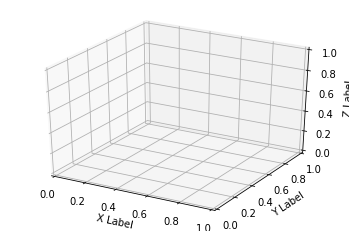

In [7]:
ax = plt.axes(projection='3d')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

x = positions[max_train_ind,0,0]
y = positions[max_train_ind,0,1]
z = positions[max_train_ind,0,2]

print(z.shape)

ax.scatter3D(xs=x, ys=y, zs=z, zdir='z', c=z, cmap='Greens', depthshade=True)
plt.show()

In [39]:
import matplotlib as mpl
import matplotlib.pylab as plt

# matching indices of mPMTS in barrel and end-caps (first and second entry, respectively)
endcap_mPMT_order = np.array([[0,6],[1,7],[2,8],[3,9],[4,10],[5,11],[6,0],[7,1],[8,2],[9,3],[10,4],[11,5],[12,15],[13,16],[14,17],[15,12],[16,13],[17,14],[18,18]])

xs = []
ys = []
hit = []
mPMT_num = []

keys = []

rand_ind = random.randrange (0, max_test_ind.shape[0], 1)
rand_ind = 32000
keys.append(rand_ind)

for i in range(40):
    for j in range(40):
        for k in range(19):
            if [i,j] in mPMT_to_index.values():
                mPMT_index = list(mPMT_to_index.keys())[list(mPMT_to_index.values()).index([i,j])]
                mPMT_pos = mPMT_to_index[mPMT_index]
                
                if PlottingEventDisplays.is_barrel(mPMT_index):
                    mPMT_location = k
                    PMT_index = mPMT_index*19 + k
                else:
                    #mPMT_location = k
                    #PMT_index = mPMT_index*19 + k
                    mPMT_location = endcap_mPMT_order[k,1]
                    PMT_index = mPMT_index*19 + endcap_mPMT_order[k,1] 
                    
                mPMT_num.append(mPMT_location)
                
                PMT_map = PlottingEventDisplays.mpmt_mapping(PMT_index)
                PMT_pos = [ mPMT_pos[0]+PMT_map[0], mPMT_pos[1]+PMT_map[1] ]

                xs.append(PMT_pos[0])
                ys.append(PMT_pos[1])
                hit.append(test_event_data[max_test_ind[rand_ind], 39-j, i, k])
                
                
cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, 20, 21)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

                
plt.figure(figsize=(10,8), dpi=1200)
#plot = plt.scatter(xs, ys, c=mPMT_num, s=1, cmap=cmap)
plot = plt.scatter(xs, ys, c=hit, s=1, cmap=plt.cm.magma_r)
plt.colorbar(plot)
plt.title('Particle Position: [%i,' %test_positions[max_test_ind[rand_ind]][0][0] + ' %i,' %test_positions[max_test_ind[rand_ind]][0][1] + ' %i]' %test_positions[max_test_ind[rand_ind]][0][2] + '  Angles: [%f,' %test_angles[max_test_ind[rand_ind]][0] + ' %f]' %test_angles[max_test_ind[rand_ind]][1])

'''
# create a second axes for the colorbar
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = plt.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
    spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
'''

"\n# create a second axes for the colorbar\nax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])\ncb = plt.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,\n    spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')\n"

In [ ]:
import random
import matplotlib.colors as colors
#fig, ax = plt.subplots(figsize=(16,8),facecolor='w')
fig, ax = plt.subplots(10, figsize=(160,80), facecolor='w')
cmap = plt.cm.afmhot
cmap.set_bad(color='black')
keys = []
for i in np.arange(10):
    
    k = random.randrange (0, max_test_ind.shape[0], 1)
    keys.append(k)
    a=PlottingEventDisplays.get_plot_array(test_event_data[max_test_ind[k],:,:,0:19])
    a = np.ma.masked_where(a < 0.05, a)
    ax[i].imshow(a,
               origin="upper",
               cmap=cmap,
               norm=colors.LogNorm(vmax=np.amax(test_event_data[max_test_ind[k],:,:,0:19])))
               #                               clip=True))

ax[0].set_title('Event Data, charge in mPMT',fontsize=20,fontweight='bold')

plt.show()
print(keys)
'''
b = event_data([max_train_ind,:,:,0:19])
b = np.ma.masked_where(b < 0.05, b)
b[:,0:12, 14:26]
b[:,28:40, 14:26]
'''

In [34]:
print(event_data[max_train_ind[keys[9]],:,:,0:19].shape)
print(positions[max_train_ind[keys[9]]])
print(angles[max_train_ind[keys[9]]])

(40, 40, 19)
[[-243.6523    324.8326     18.330795]]
[ 2.5091698 -2.5143092]


In [16]:
#print(test_event_data.shape)
print(test_event_data.mean())
#print(test_event_data.std())
#plt.hist(test_event_data[:100,:,:,:19].flatten())

28.067558
